<a href="https://colab.research.google.com/github/chavinlo/sd-native-training-colab/blob/main/Stable_Diffusion_Native_Training_in_Under_14GB_by_dep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion Native Training in Colab

Welcome! In this Colab Notebook we are going to finetune a Stable Diffusion model the native way. No Dreambooth, No Hypernetwork, just Native Training. The same form of training that models like Waifu Diffusion and others are using.

Due to the technical limitations of colab, we are only going to be able to train with batch size 1. If you own a GPU with higher vram than 13.5GB, feel free to run this notebook on your computer!

If you need more information of need help, feel free to join the SDTL discord server: https://discord.gg/8Sh2T6gjd2

### Distributed training
You might want to train a bigger model (like, hundreds of thousands of images)

This saturday (26th Nov.) we are going to conduct or first distributed training run! If you want to collaborate, join the server (https://discord.gg/8Sh2T6gjd2). Help us by contributing your GPU compute power into a interconected hivemind!

### Credits:
* [Haru](https://github.com/harubaru/waifu-diffusion) - Diffusers trainer code
* Hasuwoof - Bucketing code
* Dep (me) - Colab Port




---



# IMPORTANT!: Change Python version
You MUST run this BEFORE ANYTHING ELSE!

This will change the python version to 3.9, since certain dependencies (such as scipy) do not have binaries for 3.7 (colab default python version)

Run the cell (ONLY THE FIRST ONE) below

In [ ]:
import os
#install python 3.9 and dev utils
#you may not need all the dev libraries, but I haven't tested which aren't necessary.
!sudo apt-get update -y
!sudo apt-get install python3.9 python3.9-dev python3.9-distutils libpython3.9-dev

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall

#install colab's dependencies
!python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# link to the old google package
!ln -s /usr/local/lib/python3.7/dist-packages/google \
       /usr/local/lib/python3.9/dist-packages/google

print("RESTARTING KERNEL")
os.kill(os.getpid(), 9)

Once the cell above has finished executing, execute the cell below

In [ ]:
#check python version
import sys
print(sys.version)
if sys.version_info[1] == 9:
  print("Success! The running kernel is 3.9+, please continue...")
else:
  print("Running kernel is not 3.9+... report this")

# Stage 0: Dependencies
This module will install the required dependencies

In [ ]:
!nvidia-smi

In [ ]:
!pip install diffusers>=0.5.1 numpy==1.23.4 wandb==0.13.4 torch OmegaConf torchvision transformers>=4.21.0 huggingface-hub>=0.10.0 Pillow tqdm==4.64.1 ftfy==6.1.1 bitsandbytes pynvml~=11.4.1 psutil~=5.9.0 accelerate==0.13.1 scipy==1.9.3
# !pip install triton==2.0.0.dev20221120
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda --version
# !conda install xformers -c xformers/label/dev
import os



---



# Stage 1: Dataset Setup
The dataset is the group of Images (and Text) Files we are going to train the model on. The dataset must have the Images and Text files in the same folder, and pairs must match filenames. 

A more indepth explanation on dataset gathering and organization is available here, along with instructions on building your own: https://docs.google.com/document/d/15j1irOb73WqXG2nxMKpyfnBbJs4yZxbe_rzCSBoi0wQ/edit

After you are done building your dataset, you must zip it and follow one of the two options:

## Option 1: Google Drive
The fastest option is to download the dataset is using Google Drive.

Upload your ZIP file anywhere on your Google Drive that's visible (preferably in the home folder)

Then, mount your Google Drive in the "Files" Tab:

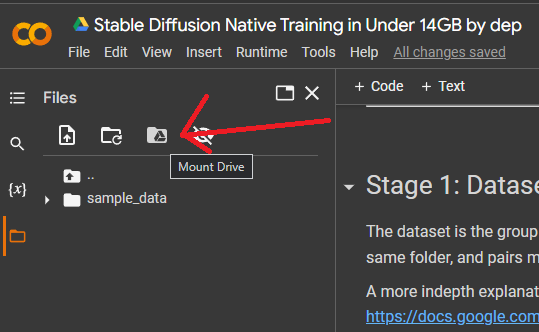





In [ ]:
import os
#@markdown Type the filename of the zipfile in the box below, then execute this cell:
filename = "mio_only.zip" #@param {type:"string"}
type_of_folder = "My Drive" #@param ["My Drive", "Shared Drive"]

if type_of_folder == "My Drive":
  os.environ["gd_foldertype"] = "MyDrive"
elif type_of_folder == "Shared Drive":
  os.environ["gd_foldertype"] = "Shareddrives"

os.environ["gd_filename"] = filename

!find /content/drive/$gd_foldertype -type f -name $gd_filename > obtained_path.tmp
path = str(open("obtained_path.tmp", "r").read()).replace('\n', '').replace('\r', '')
print("Path Found: " + path)
print("Unzipping")
import zipfile
zipobj = zipfile.ZipFile(path, 'r')
zipobj.extractall("/content/dataset")
zipobj.close()

!find /content/dataset -type f -print0 | xargs -0 mv -t /content/dataset
!rm -R -- /content/dataset/*/

## Option 2: Manual Upload
This is the simplest but slowest option.

Run the cell below, it will give you a box to upload your ZIP file and extract it:

In [ ]:
from google.colab import files
print("Uploading...")
uploadinfo = files.upload()
filename = list(uploadinfo.keys())[0]
print("Upload succeded")
print("Filename: " + str(filename))
print("Unzipping")
import zipfile
zipobj = zipfile.ZipFile(filename, 'r')
zipobj.extractall("/content/dataset")
zipobj.close()

!find /content/dataset -type f -print0 | xargs -0 mv -t /content/dataset
!rm -R -- /content/dataset/*/

In [ ]:
#@markdown ### Util: Clear Dataset Folder
!rm -dr /content/dataset



---



# Stage 2: Model Preparation
Here we will chosse the model we want to train on top of (as this is finetuning)


## Option 1: Diffuser model from HuggingFaces
This is the easiest option because the script uses diffusers, hence, it has direct integration with diffusers models uploaded on the site.

Public diffuser models can be downloaded out-of-the-box, but private models or models attached to an EULA (such as Stable Diffusion) require a HuggingFace Token.

In [ ]:
#@markdown Type the name of the model you want to use below:
model_name = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}
#@markdown If you want to use authentication:

#@markdown Tick the box below:
enable_authentication = True #@param {type:"boolean"}
#@markdown Fill this with your HF token (find it at https://huggingface.co/settings/tokens):
hf_token_string = "" #@param {type:"string"}

if enable_authentication:
  from huggingface_hub import login
  login(hf_token_string, False)

model_type = "usual_diffuser"

## Option 2: CKPT model to Diffusers
If you want to train a model on a model thats on CKPT format, you are gonna have to convert it. You can do this with a script, but first you need to upload it.

In [ ]:
import os
#@markdown Due to how big the file is, I'm only going to support Google Drive import. Just like before, upload the CKPT model to your google drive, preferably in the Home folder.

#@markdown Type the filename of the CKPT in the box below:
filename = "Filename Goes Here" #@param {type:"string"}
type_of_folder = "My Drive" #@param ["My Drive", "Shared Drive"]

if type_of_folder == "My Drive":
  os.environ["gd_foldertype"] = "MyDrive"
elif type_of_folder == "Shared Drive":
  os.environ["gd_foldertype"] = "Shareddrives"

os.environ["gd_filename"] = filename

!find /content/drive/$gd_foldertype -type f -name $gd_filename > obtained_path.tmp
path = str(open("obtained_path.tmp", "r").read()).replace('\n', '').replace('\r', '')
print("Path Found: " + path)
os.environ["ckpt_path"] = path

!wget https://raw.githubusercontent.com/huggingface/diffusers/d9cfe325a53502641f16ce4f839391c5b0d0a684/scripts/convert_original_stable_diffusion_to_diffusers.py -O convert.py

!py --checkpoint_path $ckpt_path --dump_path /content/diffuser_dump

model_name = "/content/diffuser_dump"
model_type = "converted_from_ckpt"



---



# Stage 3: Training

This is the most important section and the one that will take the most time.

Please make sure you have: Downloaded the dataset and Set up the model to train on top of.

In [ ]:
#@markdown ## Configuration
#@markdown Select the configuration to use during training. A brief description is provided.

#@markdown ### Required
#@markdown Name of the finetune run
run_name = "myNewFinetune" #@param {type:"string"}
model = model_name
dataset_path = "/content/dataset/"
print(dataset_path)

/content/dataset/


## Optional
You MUST run this cell too. If you want you can open it and modify it, but remember, the default settings are the recommended ones. You might break the configuration if you change something you don't know.

In [ ]:

#@markdown Learning Rate (converted to float)
input_lr = "5e-6" #@param {type:"string"}
lr = float(input_lr)
#@markdown Number of epochs to train for
epochs = 10 #@param {type:"integer"}
#@markdown Batch size (More consumes more VRAM)
batch_size = 1 #@param {type:"integer"}
#@markdown Enable Gradient Checkpointing (Less VRAM usage)
gradient_checkpointing = True #@param {type:"boolean"}
#@markdown Use 8-bit Adam Optimizer (only works in certain setups)
use_8bit_adam = True #@param {type:"boolean"}
#@markdown Seed for random number generator, this is to be used for reproduceability purposes.
seed = 42 #@param {type:"integer"}
#@markdown Root path for all outputs
output_path = "/content/output" #@param {type:"string"}
#@markdown Number of steps to save checkpoints at. Set this to a high number to avoid filling up space.
 
#@markdown batch size * number of images = total number of steps
save_steps = 1000 #@param {type:"integer"}
#@markdown Train in mixed precision
fp16 = True #@param {type:"boolean"}
#@markdown Use penultimate CLIP layer for text embedding
clip_penultimate = True #@param {type:"boolean"}
#@markdown Resize dataset Images (Highly recommended)
resize = True #@param {type:"boolean"}
#@markdown Use memory efficient attention (Do not enable, broken at the moment)
use_xformers = False #@param {type:"boolean"}

In [ ]:
#@markdown ### WeightsAndBiases Reporting
#@markdown Enable Weights and Biases Reporting
enablewandb = False #@param {type:"boolean"}
#@markdown Project ID for reporting to WandB
project_id = "" #@param {type:"string"}


In [ ]:
#@markdown ### Inference Configuration
#@markdown Enable Inference during training (Consumes 2GB of VRAM)
enableinference = False #@param {type:"boolean"}
#@markdown Number of steps to log images at.
image_log_steps = 500 #@param {type:"integer"}
#@markdown Number of images to log every image_log_steps
image_log_amount = 5 #@param {type:"integer"}
#@markdown Number of inference steps to use to log images.
image_log_inference_steps = 25 #@param {type:"integer"}


In [ ]:
#@markdown ### Advanced
#@markdown Perform extended validation of images to catch truncated or corrupt images.
extended_validation = False #@param {type:"boolean"}
#@markdown Skip validation of images, useful for speeding up loading of very large datasets that have already been validated.
skip_validation = False #@param {type:"boolean"}
#@markdown Number of buckets
num_buckets = 16 #@param {type:"integer"}
#@markdown The minimum side length of a bucket.
bucket_side_min = 256 #@param {type:"integer"}
#@markdown The maximum side length of a bucket.
bucket_side_max = 256 #@param {type:"integer"}
#@markdown Use EMA for finetuning
use_ema = False #@param {type:"boolean"}
#@markdown Percentage chance of dropping out the text condition per batch. Ranges from 0.0 to 1.0 where 1.0 means 100% text condition dropout.
ucg_input = "0.1" #@param {type:"string"}
ucg = float(ucg_input)

no_migration = True

## Setup

In [ ]:
# Imports
import argparse
import socket
import torch
import torchvision
import transformers
import diffusers
import os
import glob
import random
import tqdm
import resource
import psutil
import pynvml
import wandb
import gc
import time
import itertools
import numpy as np
import json
import re
import traceback
import shutil

from typing import Iterable
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler, DDIMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from diffusers.optimization import get_scheduler
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from PIL import Image, ImageOps
from PIL.Image import Image as Img

from typing import Dict, List, Generator, Tuple
from scipy.interpolate import interp1d

In [ ]:
# Bucketing things

def _sort_by_ratio(bucket: tuple) -> float:
    return bucket[0] / bucket[1]

def _sort_by_area(bucket: tuple) -> float:
    return bucket[0] * bucket[1]

class Validation():
    def __init__(self, is_skipped: bool, is_extended: bool) -> None:
        if is_skipped:
            self.validate = self.__no_op
            return print("Validation: Skipped")

        if is_extended:
            self.validate = self.__extended_validate
            return print("Validation: Extended")

        self.validate = self.__validate
        print("Validation: Standard")

    def __validate(self, fp: str) -> bool:
        try:
            Image.open(fp)
            return True
        except:
            print(f'WARNING: Image cannot be opened: {fp}')
            return False

    def __extended_validate(self, fp: str) -> bool:
        try:
            Image.open(fp).load()
            return True
        except (OSError) as error:
            if 'truncated' in str(error):
                print(f'WARNING: Image truncated: {error}')
                return False
            print(f'WARNING: Image cannot be opened: {error}')
            return False
        except:
            print(f'WARNING: Image cannot be opened: {error}')
            return False

    def __no_op(self, fp: str) -> bool:
        return True

class Resize():
    def __init__(self, is_resizing: bool, is_not_migrating: bool) -> None:
        if not is_resizing:
            self.resize = self.__no_op
            return

        if not is_not_migrating:
            self.resize = self.__migration
            dataset_path = os.path.split(dataset_path)
            self.__directory = os.path.join(
                dataset_path[0],
                f'{dataset_path[1]}_cropped'
            )
            os.makedirs(self.__directory, exist_ok=True)
            return print(f"Resizing: Performing migration to '{self.__directory}'.")

        self.resize = self.__no_migration

    def __no_migration(self, image_path: str, w: int, h: int) -> Img:
        return ImageOps.fit(
                Image.open(image_path),
                (w, h),
                bleed=0.0,
                centering=(0.5, 0.5),
                method=Image.Resampling.LANCZOS
            ).convert(mode='RGB')

    def __migration(self, image_path: str, w: int, h: int) -> Img:
        filename = re.sub('\.[^/.]+$', '', os.path.split(image_path)[1])

        image = ImageOps.fit(
                Image.open(image_path),
                (w, h),
                bleed=0.0,
                centering=(0.5, 0.5),
                method=Image.Resampling.LANCZOS
            ).convert(mode='RGB')

        image.save(
            os.path.join(f'{self.__directory}', f'{filename}.jpg'),
            optimize=True
        )

        try:
            shutil.copy(
                os.path.join(dataset_path, f'{filename}.txt'),
                os.path.join(self.__directory, f'{filename}.txt'),
                follow_symlinks=False
            )
        except (FileNotFoundError):
            f = open(
                os.path.join(self.__directory, f'{filename}.txt'),
                'w',
                encoding='UTF-8'
            )
            f.close()

        return image

    def __no_op(self, image_path: str, w: int, h: int) -> Img:
        return Image.open(image_path)

class ImageStore:
    def __init__(self, data_dir: str) -> None:
        self.data_dir = data_dir

        self.image_files = []
        [self.image_files.extend(glob.glob(f'{data_dir}' + '/*.' + e)) for e in ['jpg', 'jpeg', 'png', 'bmp', 'webp']]

        self.validator = Validation(
            skip_validation,
            extended_validation
        ).validate

        self.resizer = Resize(resize, no_migration).resize

        self.image_files = [x for x in self.image_files if self.validator(x)]

    def __len__(self) -> int:
        return len(self.image_files)

    # iterator returns images as PIL images and their index in the store
    def entries_iterator(self) -> Generator[Tuple[Img, int], None, None]:
        for f in range(len(self)):
            yield Image.open(self.image_files[f]), f

    # get image by index
    def get_image(self, ref: Tuple[int, int, int]) -> Img:
        return self.resizer(
            self.image_files[ref[0]],
            ref[1],
            ref[2]
        )

    # gets caption by removing the extension from the filename and replacing it with .txt
    def get_caption(self, ref: Tuple[int, int, int]) -> str:
        filename = re.sub('\.[^/.]+$', '', self.image_files[ref[0]]) + '.txt'
        with open(filename, 'r', encoding='UTF-8') as f:
            return f.read()


# ====================================== #
# Bucketing code stolen from hasuwoof:   #
# https://github.com/hasuwoof/huskystack #
# ====================================== #

class AspectBucket:
    def __init__(self, store: ImageStore,
                 num_buckets: int,
                 batch_size: int,
                 bucket_side_min: int = 256,
                 bucket_side_max: int = 768,
                 bucket_side_increment: int = 64,
                 max_image_area: int = 512 * 768,
                 max_ratio: float = 2):

        self.requested_bucket_count = num_buckets
        self.bucket_length_min = bucket_side_min
        self.bucket_length_max = bucket_side_max
        self.bucket_increment = bucket_side_increment
        self.max_image_area = max_image_area
        self.batch_size = batch_size
        self.total_dropped = 0

        if max_ratio <= 0:
            self.max_ratio = float('inf')
        else:
            self.max_ratio = max_ratio

        self.store = store
        self.buckets = []
        self._bucket_ratios = []
        self._bucket_interp = None
        self.bucket_data: Dict[tuple, List[int]] = dict()
        self.init_buckets()
        self.fill_buckets()

    def init_buckets(self):
        possible_lengths = list(range(self.bucket_length_min, self.bucket_length_max + 1, self.bucket_increment))
        possible_buckets = list((w, h) for w, h in itertools.product(possible_lengths, possible_lengths)
                        if w >= h and w * h <= self.max_image_area and w / h <= self.max_ratio)

        buckets_by_ratio = {}

        # group the buckets by their aspect ratios
        for bucket in possible_buckets:
            w, h = bucket
            # use precision to avoid spooky floats messing up your day
            ratio = '{:.4e}'.format(w / h)

            if ratio not in buckets_by_ratio:
                group = set()
                buckets_by_ratio[ratio] = group
            else:
                group = buckets_by_ratio[ratio]

            group.add(bucket)

        # now we take the list of buckets we generated and pick the largest by area for each (the first sorted)
        # then we put all of those in a list, sorted by the aspect ratio
        # the square bucket (LxL) will be the first
        unique_ratio_buckets = sorted([sorted(buckets, key=_sort_by_area)[-1]
                                       for buckets in buckets_by_ratio.values()], key=_sort_by_ratio)

        # how many buckets to create for each side of the distribution
        bucket_count_each = int(np.clip((self.requested_bucket_count + 1) / 2, 1, len(unique_ratio_buckets)))

        # we know that the requested_bucket_count must be an odd number, so the indices we calculate
        # will include the square bucket and some linearly spaced buckets along the distribution
        indices = {*np.linspace(0, len(unique_ratio_buckets) - 1, bucket_count_each, dtype=int)}

        # make the buckets, make sure they are unique (to remove the duplicated square bucket), and sort them by ratio
        # here we add the portrait buckets by reversing the dimensions of the landscape buckets we generated above
        buckets = sorted({*(unique_ratio_buckets[i] for i in indices),
                          *(tuple(reversed(unique_ratio_buckets[i])) for i in indices)}, key=_sort_by_ratio)

        self.buckets = buckets

        # cache the bucket ratios and the interpolator that will be used for calculating the best bucket later
        # the interpolator makes a 1d piecewise interpolation where the input (x-axis) is the bucket ratio,
        # and the output is the bucket index in the self.buckets array
        # to find the best fit we can just round that number to get the index
        self._bucket_ratios = [w / h for w, h in buckets]
        if len(self._bucket_ratios) > 1:
          self._bucket_interp = interp1d(self._bucket_ratios, list(range(len(buckets))), assume_sorted=True, fill_value=None)
        else:
          self._bucket_interp = lambda *_: 0

        for b in buckets:
            self.bucket_data[b] = []

    def get_batch_count(self):
        return sum(len(b) // self.batch_size for b in self.bucket_data.values())

    def get_bucket_info(self):
        return json.dumps({ "buckets": self.buckets, "bucket_ratios": self._bucket_ratios })

    def get_batch_iterator(self) -> Generator[Tuple[Tuple[int, int, int]], None, None]:
        """
        Generator that provides batches where the images in a batch fall on the same bucket

        Each element generated will be:
            (index, w, h)

        where each image is an index into the dataset
        :return:
        """
        max_bucket_len = max(len(b) for b in self.bucket_data.values())
        index_schedule = list(range(max_bucket_len))
        random.shuffle(index_schedule)

        bucket_len_table = {
            b: len(self.bucket_data[b]) for b in self.buckets
        }

        bucket_schedule = []
        for i, b in enumerate(self.buckets):
            bucket_schedule.extend([i] * (bucket_len_table[b] // self.batch_size))

        random.shuffle(bucket_schedule)

        bucket_pos = {
            b: 0 for b in self.buckets
        }

        total_generated_by_bucket = {
            b: 0 for b in self.buckets
        }

        for bucket_index in bucket_schedule:
            b = self.buckets[bucket_index]
            i = bucket_pos[b]
            bucket_len = bucket_len_table[b]

            batch = []
            while len(batch) != self.batch_size:
                # advance in the schedule until we find an index that is contained in the bucket
                k = index_schedule[i]
                if k < bucket_len:
                    entry = self.bucket_data[b][k]
                    batch.append(entry)

                i += 1

            total_generated_by_bucket[b] += self.batch_size
            bucket_pos[b] = i
            yield [(idx, *b) for idx in batch]

    def fill_buckets(self):
        entries = self.store.entries_iterator()
        total_dropped = 0

        for entry, index in tqdm.tqdm(entries, total=len(self.store)):
            if not self._process_entry(entry, index):
                total_dropped += 1

        for b, values in self.bucket_data.items():
            # shuffle the entries for extra randomness and to make sure dropped elements are also random
            random.shuffle(values)

            # make sure the buckets have an exact number of elements for the batch
            to_drop = len(values) % self.batch_size
            self.bucket_data[b] = list(values[:len(values) - to_drop])
            total_dropped += to_drop

        self.total_dropped = total_dropped

    def _process_entry(self, entry: Image.Image, index: int) -> bool:
        aspect = entry.width / entry.height

        if aspect > self.max_ratio or (1 / aspect) > self.max_ratio:
            return False

        best_bucket = self._bucket_interp(aspect)

        if best_bucket is None:
            return False

        bucket = self.buckets[round(float(best_bucket))]

        self.bucket_data[bucket].append(index)

        del entry

        return True

class AspectBucketSampler(torch.utils.data.Sampler):
    def __init__(self, bucket: AspectBucket, num_replicas: int = 1, rank: int = 0):
        super().__init__(None)
        self.bucket = bucket
        self.num_replicas = num_replicas
        self.rank = rank

    def __iter__(self):
        # subsample the bucket to only include the elements that are assigned to this rank
        indices = self.bucket.get_batch_iterator()
        indices = list(indices)[self.rank::self.num_replicas]
        return iter(indices)

    def __len__(self):
        return self.bucket.get_batch_count() // self.num_replicas

class AspectDataset(torch.utils.data.Dataset):
    def __init__(self, store: ImageStore, tokenizer: CLIPTokenizer, ucg: float = 0.1):
        self.store = store
        self.tokenizer = tokenizer
        self.ucg = ucg

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.store)

    def __getitem__(self, item: Tuple[int, int, int]):
        return_dict = {'pixel_values': None, 'input_ids': None}

        image_file = self.store.get_image(item)

        return_dict['pixel_values'] = self.transforms(image_file)
        if random.random() > self.ucg:
            caption_file = self.store.get_caption(item)
        else:
            caption_file = ''
        return_dict['input_ids'] = self.tokenizer(caption_file, max_length=self.tokenizer.model_max_length, padding='do_not_pad', truncation=True).input_ids

        return return_dict

    def collate_fn(self, examples):
            pixel_values = torch.stack([example['pixel_values'] for example in examples if example is not None])
            pixel_values.to(memory_format=torch.contiguous_format).float()
            input_ids = [example['input_ids'] for example in examples if example is not None]
            padded_tokens = self.tokenizer.pad({'input_ids': input_ids}, return_tensors='pt', padding=True)
            return {
                'pixel_values': pixel_values,
                'input_ids': padded_tokens.input_ids,
                'attention_mask': padded_tokens.attention_mask,
            }


In [ ]:
# Adapted from torch-ema https://github.com/fadel/pytorch_ema/blob/master/torch_ema/ema.py#L14
class EMAModel:
    """
    Exponential Moving Average of models weights
    """

    def __init__(self, parameters: Iterable[torch.nn.Parameter], decay=0.9999):
        parameters = list(parameters)
        self.shadow_params = [p.clone().detach() for p in parameters]

        self.decay = decay
        self.optimization_step = 0

    def get_decay(self, optimization_step):
        """
        Compute the decay factor for the exponential moving average.
        """
        value = (1 + optimization_step) / (10 + optimization_step)
        return 1 - min(self.decay, value)

    @torch.no_grad()
    def step(self, parameters):
        parameters = list(parameters)

        self.optimization_step += 1
        self.decay = self.get_decay(self.optimization_step)

        for s_param, param in zip(self.shadow_params, parameters):
            if param.requires_grad:
                tmp = self.decay * (s_param - param)
                s_param.sub_(tmp)
            else:
                s_param.copy_(param)

        torch.cuda.empty_cache()

    def copy_to(self, parameters: Iterable[torch.nn.Parameter]) -> None:
        """
        Copy current averaged parameters into given collection of parameters.
        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                updated with the stored moving averages. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        parameters = list(parameters)
        for s_param, param in zip(self.shadow_params, parameters):
            param.data.copy_(s_param.data)

    # From CompVis LitEMA implementation
    def store(self, parameters):
        """
        Save the current parameters for restoring later.
        Args:
          parameters: Iterable of `torch.nn.Parameter`; the parameters to be
            temporarily stored.
        """
        self.collected_params = [param.clone() for param in parameters]

    def restore(self, parameters):
        """
        Restore the parameters stored with the `store` method.
        Useful to validate the model with EMA parameters without affecting the
        original optimization process. Store the parameters before the
        `copy_to` method. After validation (or model saving), use this to
        restore the former parameters.
        Args:
          parameters: Iterable of `torch.nn.Parameter`; the parameters to be
            updated with the stored parameters.
        """
        for c_param, param in zip(self.collected_params, parameters):
            param.data.copy_(c_param.data)

        del self.collected_params
        gc.collect()

    def to(self, device=None, dtype=None) -> None:
        r"""Move internal buffers of the ExponentialMovingAverage to `device`.
        Args:
            device: like `device` argument to `torch.Tensor.to`
        """
        # .to() on the tensors handles None correctly
        self.shadow_params = [
            p.to(device=device, dtype=dtype) if p.is_floating_point() else p.to(device=device)
            for p in self.shadow_params
        ]


## Run!

In [ ]:
os.makedirs(output_path, exist_ok=True)

mode = 'disabled'
if enablewandb:
    mode = 'online'
if hf_token_string is not None:
    os.environ['HF_API_TOKEN'] = hf_token_string
    hf_token_string = None
run = wandb.init(project=project_id, name=run_name, dir=output_path+'/wandb', mode=mode)

# Inform the user of host, and various versions -- useful for debugging issues.
print("RUN_NAME:", run_name)
print("HOST:", socket.gethostname())
print("CUDA:", torch.version.cuda)
print("TORCH:", torch.__version__)
print("TRANSFORMERS:", transformers.__version__)
print("DIFFUSERS:", diffusers.__version__)
print("MODEL:", model_name)
print("FP16:", fp16)
resolution = 512
print("RESOLUTION:", resolution)

if hf_token_string is not None:
    print('It is recommended to set the HF_API_TOKEN environment variable instead of passing it as a command line argument since WandB will automatically log it.')
else:
    try:
        hf_token_string = os.environ['HF_API_TOKEN']
        print("HF Token set via enviroment variable")
    except Exception:
        print("No HF Token detected in arguments or enviroment variable, setting it to none (as in string)")
        hf_token_string = "none"

device = torch.device('cuda')

print("DEVICE:", device)

# setup fp16 stuff
scaler = torch.cuda.amp.GradScaler(enabled=fp16)

# Set seed
torch.manual_seed(seed)
print('RANDOM SEED:', seed)

#TODO: not yet
# if args.resume:
#     args.model = args.resume

tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder='tokenizer', use_auth_token=hf_token_string)
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder='text_encoder', use_auth_token=hf_token_string)
vae = AutoencoderKL.from_pretrained(model_name, subfolder='vae', use_auth_token=hf_token_string)
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder='unet', use_auth_token=hf_token_string)


# Freeze vae and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

if gradient_checkpointing:
    unet.enable_gradient_checkpointing()

if use_xformers:
    unet.set_use_memory_efficient_attention_xformers(True)

# "The “safer” approach would be to move the model to the device first and create the optimizer afterwards."
weight_dtype = torch.float16 if fp16 else torch.float32

# move models to device
vae = vae.to(device, dtype=weight_dtype)
unet = unet.to(device, dtype=torch.float32)
text_encoder = text_encoder.to(device, dtype=weight_dtype)
    
if use_8bit_adam: # Bits and bytes is only supported on certain CUDA setups, so default to regular adam if it fails.
    try:
        import bitsandbytes as bnb
        optimizer_cls = bnb.optim.AdamW8bit
    except:
        print('bitsandbytes not supported, using regular Adam optimizer')
        optimizer_cls = torch.optim.AdamW
else:
    optimizer_cls = torch.optim.AdamW

optimizer = optimizer_cls(
    unet.parameters(),
    lr=lr,
    betas=(float(0.9), float(0.999)),
    eps=float(1e-2),
    weight_decay=float(1e-2),
)

noise_scheduler = DDPMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule='scaled_linear',
    num_train_timesteps=1000,
    clip_sample=False
)

# load dataset
print("Dataset located at: ", dataset_path)
store = ImageStore(dataset_path)
print(f'STORE_LEN: {len(store)}')
dataset = AspectDataset(store, tokenizer)
bucket = AspectBucket(store, num_buckets, batch_size, bucket_side_min, bucket_side_max, 64, resolution * resolution, 2.0)
sampler = AspectBucketSampler(bucket=bucket, num_replicas=1, rank=0)



# if args.output_bucket_info:
#     print(bucket.get_bucket_info())
#     exit(0)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_sampler=sampler,
    num_workers=0,
    collate_fn=dataset.collate_fn
)

# Migrate dataset
if resize and not no_migration:
    for _, batch in enumerate(train_dataloader):
        continue
    print(f"Completed resize and migration to '{dataset_path}_cropped' please relaunch the trainer without the --resize argument and train on the migrated dataset.")
    exit(0)

#unet = torch.nn.parallel.DistributedDataParallel(unet, device_ids=[rank], output_device=rank, gradient_as_bucket_view=True)

# create ema
if use_ema:
    ema_unet = EMAModel(unet.parameters())

num_steps_per_epoch = len(train_dataloader)
progress_bar = tqdm.tqdm(range(epochs * num_steps_per_epoch), desc="Total Steps", leave=False)
global_step = 0

# if args.resume:
#     target_global_step = int(args.resume.split('_')[-1])
#     print(f'resuming from {args.resume}...')

lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=int(float(0.05) * num_steps_per_epoch * epochs),
    num_training_steps=epochs * num_steps_per_epoch,
    #last_epoch=(global_step // num_steps_per_epoch) - 1,
)

def save_checkpoint(global_step):
      if use_ema:
          ema_unet.store(unet.parameters())
          ema_unet.copy_to(unet.parameters())
      pipeline = StableDiffusionPipeline(
          text_encoder=text_encoder,
          vae=vae,
          unet=unet,
          tokenizer=tokenizer,
          scheduler=PNDMScheduler(
              beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
          ),
          safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
          feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
      )
      print(f'saving checkpoint to: {output_path}/{run_name}_{global_step}')
      pipeline.save_pretrained(f'{output_path}/{run_name}_{global_step}')

      if use_ema:
          ema_unet.restore(unet.parameters())

try:
    loss = torch.tensor(0.0, device=device, dtype=weight_dtype)
    for epoch in range(epochs):
        unet.train()
        for _, batch in enumerate(train_dataloader):
            # if args.resume and global_step < target_global_step:
            #     if rank == 0:
            #         progress_bar.update(1)
            #     global_step += 1
            #     continue
            b_start = time.perf_counter()
            latents = vae.encode(batch['pixel_values'].to(device, dtype=weight_dtype)).latent_dist.sample()
            latents = latents * 0.18215

            # Sample noise
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch['input_ids'].to(device), output_hidden_states=True)
            if clip_penultimate:
                encoder_hidden_states = text_encoder.text_model.final_layer_norm(encoder_hidden_states['hidden_states'][-2])
            else:
                encoder_hidden_states = encoder_hidden_states.last_hidden_state

            # Predict the noise residual and compute loss
            with torch.autocast('cuda', enabled=fp16):
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

            loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

            # Backprop and all reduce
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Update EMA
            if use_ema:
                ema_unet.step(unet.parameters())

            # perf
            b_end = time.perf_counter()
            seconds_per_step = b_end - b_start
            steps_per_second = 1 / seconds_per_step
            rank_images_per_second = batch_size * steps_per_second
            world_images_per_second = rank_images_per_second * 1
            samples_seen = global_step * batch_size * 1


            progress_bar.update(1)
            global_step += 1
            logs = {
                "train/loss": loss.detach().item() / 1,
                "train/lr": lr_scheduler.get_last_lr()[0],
                "train/epoch": epoch,
                "train/step": global_step,
                "train/samples_seen": samples_seen,
                "perf/rank_samples_per_second": rank_images_per_second,
                "perf/global_samples_per_second": world_images_per_second,
            }
            progress_bar.set_postfix(logs)
            run.log(logs, step=global_step)

            if global_step % save_steps == 0:
                save_checkpoint(global_step)

            if enableinference:
                if global_step % image_log_steps == 0:
                    # get prompt from random batch
                    prompt = tokenizer.decode(batch['input_ids'][random.randint(0, len(batch['input_ids'])-1)].tolist())

                    # if args.image_log_scheduler == 'DDIMScheduler':
                    #     print('using DDIMScheduler scheduler')
                    #     scheduler = DDIMScheduler(
                    #         beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear"
                    #     )
                    # else:
                    print('using PNDMScheduler scheduler')
                    scheduler=PNDMScheduler(
                        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
                    )

                    pipeline = StableDiffusionPipeline(
                        text_encoder=text_encoder,
                        vae=vae,
                        unet=unet,
                        tokenizer=tokenizer,
                        scheduler=scheduler,
                        safety_checker=None, # disable safety checker to save memory
                        feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
                    ).to(device)
                    # inference
                    if enablewandb:
                        images = []
                    else:
                        saveInferencePath = output_path + "/inference"
                        os.makedirs(saveInferencePath, exist_ok=True)
                    with torch.no_grad():
                        with torch.autocast('cuda', enabled=fp16):
                            for _ in range(image_log_amount):
                                if enablewandb:
                                    images.append(
                                        wandb.Image(pipeline(
                                            prompt, num_inference_steps=image_log_inference_steps
                                        ).images[0],
                                        caption=prompt)
                                    )
                                else:
                                    from datetime import datetime
                                    images = pipeline(prompt, num_inference_steps=image_log_inference_steps).images[0]
                                    filenameImg = str(time.time_ns()) + ".png"
                                    filenameTxt = str(time.time_ns()) + ".txt"
                                    images.save(saveInferencePath + "/" + filenameImg)
                                    with open(saveInferencePath + "/" + filenameTxt, 'a') as f:
                                        f.write('Used prompt: ' + prompt + '\n')
                                        f.write('Generated Image Filename: ' + filenameImg + '\n')
                                        f.write('Generated at: ' + str(global_step) + ' steps' + '\n')
                                        f.write('Generated at: ' + str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))+ '\n')

                    # log images under single caption
                    if enablewandb:
                        run.log({'images': images}, step=global_step)

                    # cleanup so we don't run out of memory
                    del pipeline
                    gc.collect()
except Exception as e:
    print(f'Exception at step {global_step}, saving checkpoint...\n{e}\n{traceback.format_exc()}')
    pass

save_checkpoint(global_step)

print('Done!')

## Once the training has finished, you can download your model:


### Option 1: Google Drive

In [ ]:
#@markdown Run this cell to obtain what checkpoints are available
from os.path import isfile, join
onlyfiles = [f for f in listdir(output_path)]
print("Available Checkpoints:")
index = 0
for i in onlyfiles:
  index = index + 1
  print(index, "-", i)
print("The higher the number at the end, the more steps it has been trained for.")

Available Checkpoints:
The higher the number at the end, the more steps it has been trained for.


In [ ]:
import os
#@markdown Select the step count below:
step_count = 0 #@param {type:"integer"}
#@markdown Select where to save:
type_of_folder = "Shared Drive" #@param ["My Drive", "Shared Drive"]
#@markdown If necesary, set a custom path to save at. Else leave it on "none"
custom_path = "gd-one" #@param {type:"string"}

model_to_save = output_path + "/" + run_name + "_" + str(step_count)
print("Saving:", model_to_save)

if os.path.isdir(model_to_save):
  print("Model does exist")
else:
  raise Exception("Model does not exist. Check the parameters again please")

if type_of_folder == "My Drive":
  if custom_path == "none":
    path_to_save_at = "/content/drive/MyDrive/"
  else:
    path_to_save_at = "/content/drive/MyDrive/" + custom_path
elif type_of_folder == "Shared Drive":
  if custom_path == "none":
    path_to_save_at = "/content/drive/Shareddrives/"
  else:
    path_to_save_at = "/content/drive/Shareddrives/" + custom_path

print("Saving on:", path_to_save_at)

import shutil
print("Saving... this might take a long time")
shutil.move(model_to_save, path_to_save_at)
print("Model saved at", path_to_save_at)

Saving: /content/output/myNewFinetune_0
Model does exist
Saving on: /content/drive/Shareddrives/gd-one
Saving... this might take a long time


'/content/drive/Shareddrives/gd-one/myNewFinetune_0'

# Congratulations!
You just trained your own finetune. You can now access it on the path provided path.

Remember:

### Diffuser format conversion to CKPT:
The model is in diffusers format. Heres a convertor to CKPT: https://gist.github.com/chavinlo/93fd4bf910dfaa6781fbaec87b816493 

Before running it, install `pip install torch OmegaConf`. Although you probably already have them.

Download the model, its going to be a folder.

Download the script.

And execute `python3 --model_path PATH_TO_FOLDER_GOES_HERE --checkpoint_path PATH_TO_OUTPUT_CKPT_CHECKPOINT_GOES_HERE`

## Support

If you need help using this colab, or have suggestions, please let me know on the SD Training Labs discord server:

https://discord.gg/8Sh2T6gjd2 - 2.2K members!!!

## Distributed training & training platform
You might want to train a bigger model (like, hundreds of thousands of images)

I'm working on both distributed model training, and, a training web platform.

This saturday (26th Nov.) we are going to conduct or first distributed training run! If you want to collaborate, join the server mentioned above. Help us by contributing your GPU compute power into a interconected hivemind!
